In [ ]:
import os
import sys
import importlib
# Add utilities to path (utilities is one directory down from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import time

import utilities.pdf_extraction_utils
importlib.reload(utilities.pdf_extraction_utils)
from utilities.pdf_extraction_utils import (
    ExtractionConfig,
    load_pdf_page,
    analyze_layers,
    extract_polygons_from_layer,
    batch_extract_polygons,
    visualize_extraction_results,
    save_polygons_to_json,
    load_polygons_from_json,
    build_clip_map,
    filter_layer_paths,
    extract_lines_from_paths,
    cluster_and_snap_endpoints,
    extend_dangles,
    polygonize_lines,
    plot_polygons_on_pdf,
)

In [2]:
test_pdf = "C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf"
test_layer = "E-CB_AREA"
config = ExtractionConfig()
file_path = test_pdf
layer_name = test_layer
page_number = 0

result = extract_polygons_from_layer(file_path, page_number, layer_name, config)

In [3]:
result

{'success': False,
 'error': 'No paths found for layer: E-CB_AREA',
 'polygons': [],
 'processing_time': 32.25514221191406}

🔧 Testing corrected implementation...
Testing: NorthStar As Built - Rev 2 2016-11-15.pdf, Page: 44, Layer: E-CB_AREA
Config: TOL=1.0, EXT=40.0, GRID_SIZE=3.0
✅ SUCCESS!
  📊 Statistics:
    total_drawings: 27483
    layer_paths: 1134
    filtered_paths: 1106
    lines_extracted: 574
    lines_snapped: 574
    extensions: 1078
    polygons: 22
    total_area: 2027700.0
  ⏱️  Processing time: 8.58s
  🔺 Polygons found: 22


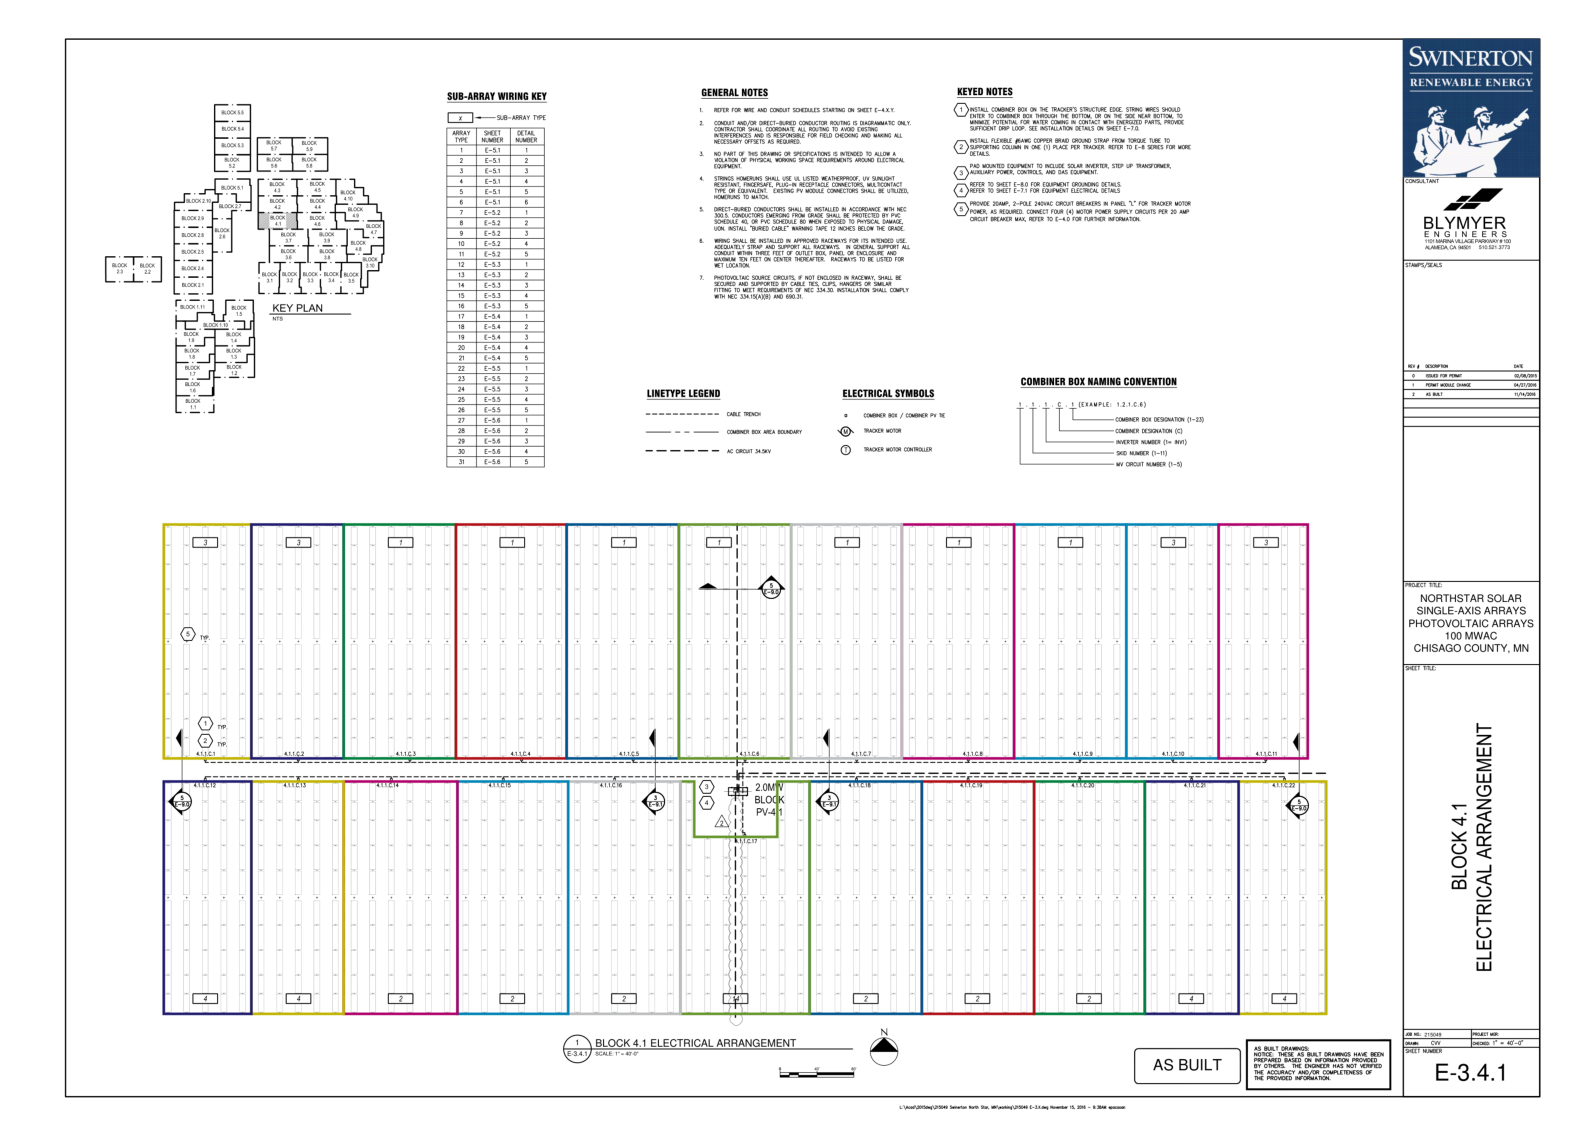

In [19]:
# Test the corrected implementation matching the original pipeline
print("🔧 Testing corrected implementation...")

if test_pdf:
    test_page = 44  # Using same page as original (NorthStar page 14)
    test_layer = "E-CB_AREA"  # Known good layer
    
    print(f"Testing: {os.path.basename(test_pdf)}, Page: {test_page}, Layer: {test_layer}")
    
    try:
        config = ExtractionConfig()
        print(f"Config: TOL={config.tolerance}, EXT={config.extension_length}, GRID_SIZE={config.grid_size}")
        
        result = extract_polygons_from_layer(test_pdf, test_page, test_layer, config)
        
        if result['success']:
            print(f"✅ SUCCESS!")
            print(f"  📊 Statistics:")
            for key, value in result['stats'].items():
                print(f"    {key}: {value}")
            print(f"  ⏱️  Processing time: {result['processing_time']:.2f}s")
            print(f"  🔺 Polygons found: {len(result['polygons'])}")
        else:
            print(f"❌ FAILED: {result['error']}")
            if 'traceback' in result:
                print("Full traceback:")
                print(result['traceback'])
                
    except Exception as e:
        print(f"❌ EXCEPTION: {str(e)}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No PDF files found for testing")

plot_polygons_on_pdf(result, file_path)


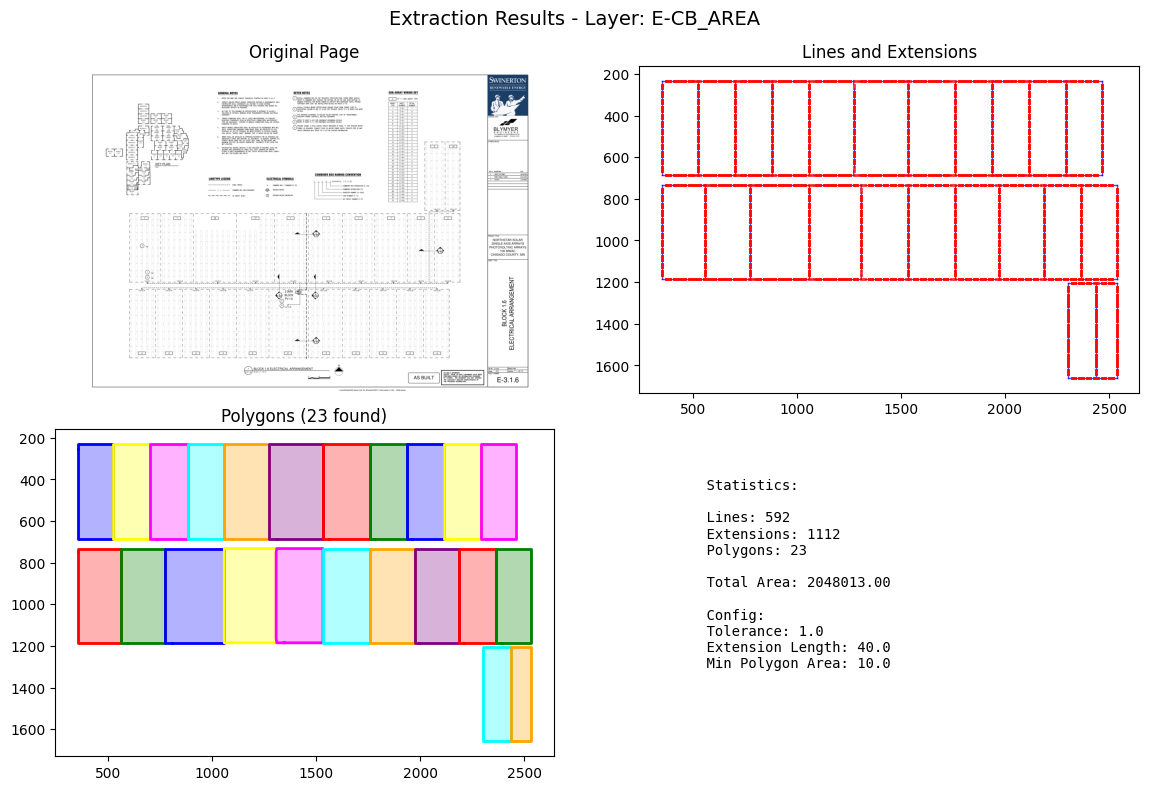

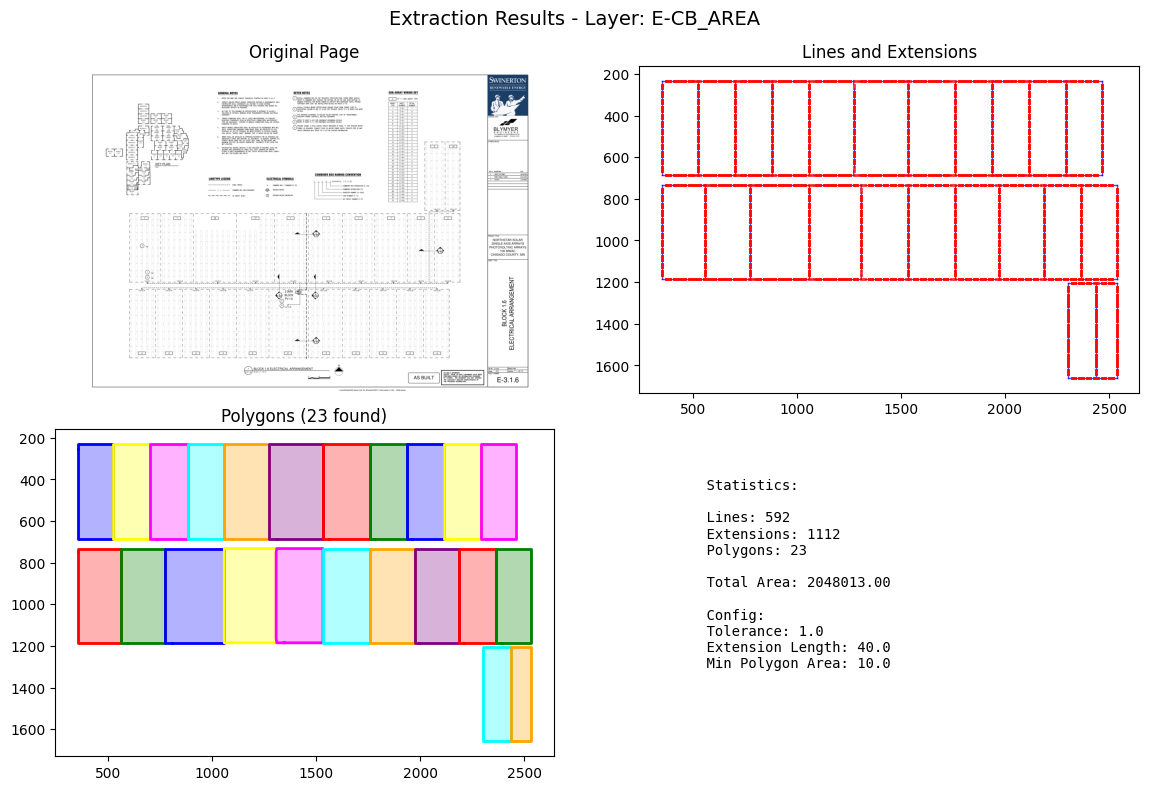

In [18]:
visualize_extraction_results(
    result['page'],
    result['lines'],
    result['extensions'],
    result['polygons'],
    dangles=result.get('dangles', None),
    layer_name=result.get('layer_name', ''),
    config=result.get('config', None)
)

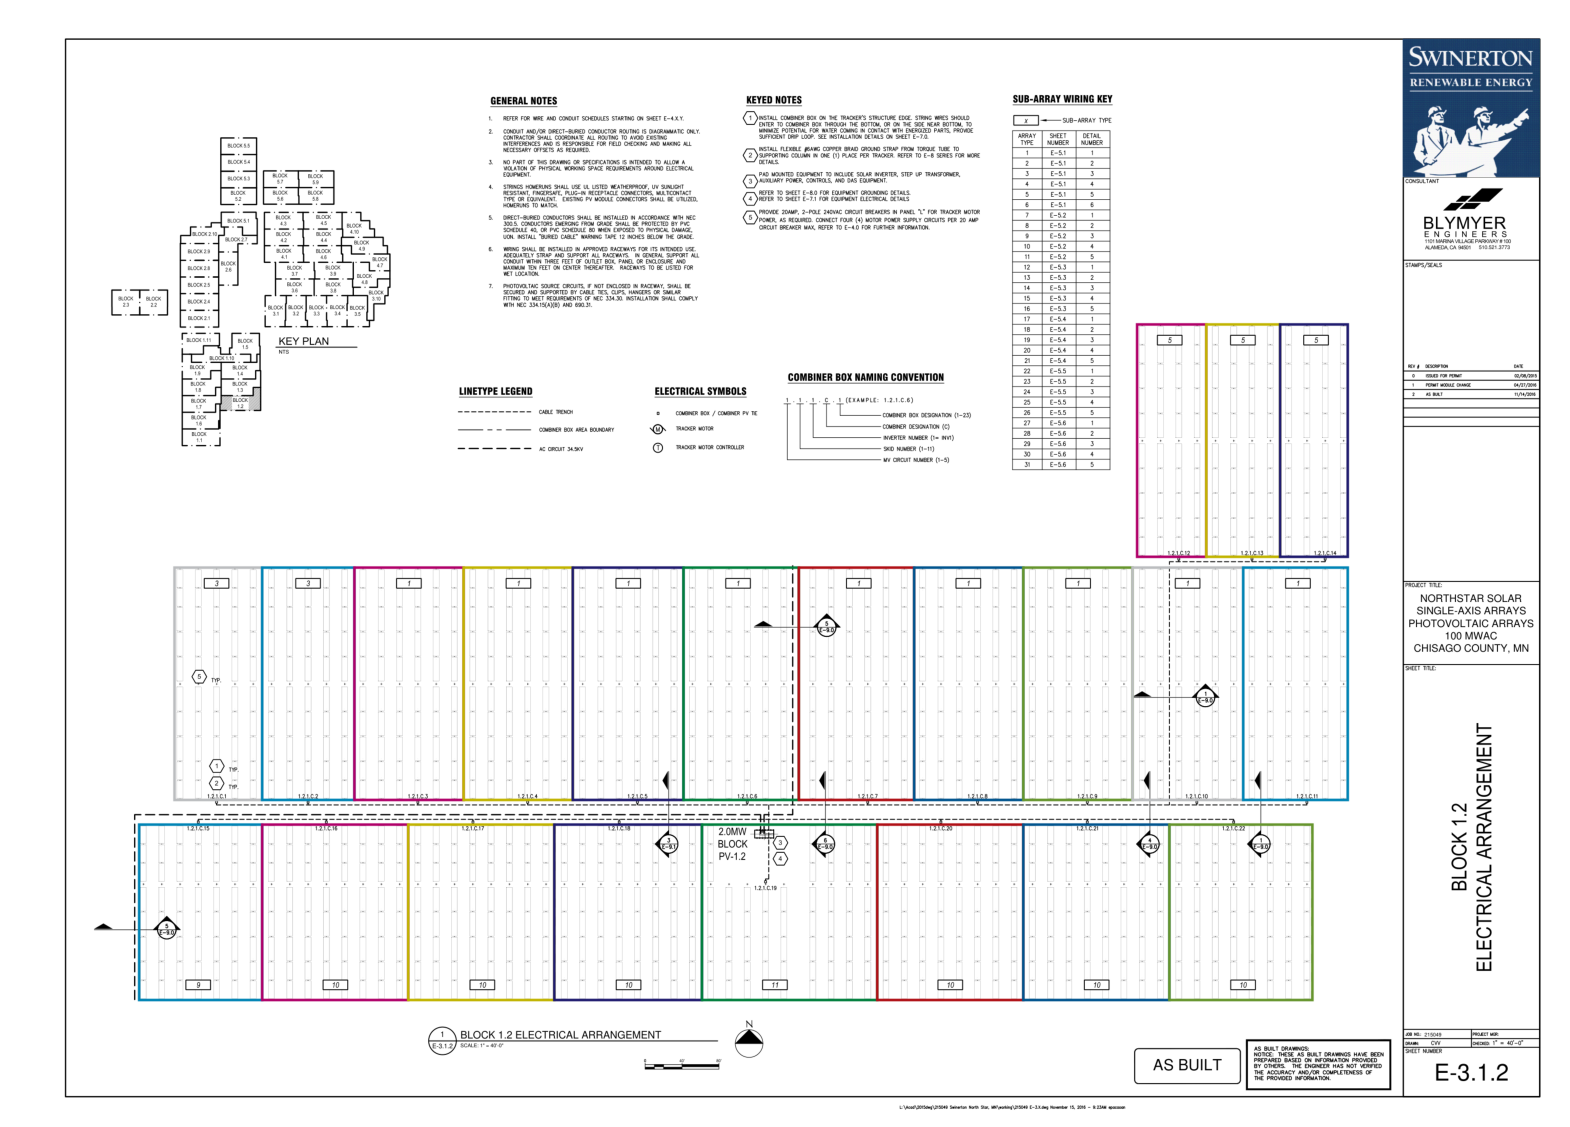

In [13]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import fitz  # PyMuPDF
import io
from PIL import Image

def plot_polygons_on_pdf(result, file_path=None, figsize=(20, 20)):
    """
    Plots extracted polygons overlaid on the PDF page image in a notebook.

    Parameters:
        result: dict, output from extract_polygons_from_layer
        file_path: str or None, path to the PDF file (if not in result)
        figsize: tuple, size of the matplotlib figure
    """
    pdf_path = file_path if file_path is not None else result.get('file_path', None)
    if pdf_path is None:
        raise ValueError("PDF file path must be provided either as argument or in result['file_path']")
    page_obj = result.get('page')
    page_number = page_obj.number if hasattr(page_obj, 'number') else 0

    doc = fitz.open(pdf_path)
    outpage = doc[page_number]
    shape = outpage.new_shape()

    colors = [
        (1, 0, 0),  # red
        (0, 1, 0),  # green
        (0, 0, 1),  # blue
        (1, 1, 0),  # yellow
        (1, 0, 1),  # magenta
        (0, 1, 1),  # cyan
        (1, 0.5, 0),  # orange
        (0.5, 0, 1),  # purple
        (0, 0, 0),    # black
    ]

    for i, poly in enumerate(result['polygons']):
        x, y = poly.exterior.xy
        color = colors[i % len(colors)]
        points = list(zip(x, y))
        shape.draw_polyline(points)
        shape.finish(
            color=color + (0.3,),
            width=5
        )

    shape.commit()

    fig, ax = plt.subplots(figsize=figsize)
    pix = outpage.get_pixmap()
    img = pix.tobytes("png")
    im = Image.open(io.BytesIO(img))
    ax.imshow(im)
    ax.axis('off')
    plt.show()

# Example usage:
plot_polygons_on_pdf(result, file_path)

# Batch Test


In [ ]:
page_numbers = [14,15,16,17]
layer_names = ["E-CB_AREA","E-CB_AREA","E-CB_AREA","E-CB_AREA"]
file_paths = [file_path] * len(page_numbers)
config = ExtractionConfig()

results = batch_extract_polygons(file_paths, page_numbers, layer_names, config)

Processing 1/4: NorthStar As Built - Rev 2 2016-11-15.pdf_p14_E-CB_AREA
Processing 2/4: NorthStar As Built - Rev 2 2016-11-15.pdf_p15_E-CB_AREA
Processing 3/4: NorthStar As Built - Rev 2 2016-11-15.pdf_p16_E-CB_AREA
Processing 4/4: NorthStar As Built - Rev 2 2016-11-15.pdf_p17_E-CB_AREA


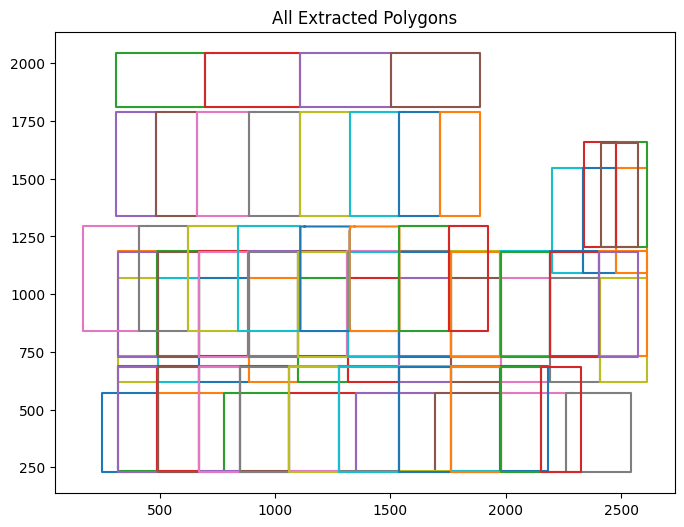

In [35]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

all_polygons = []
for res in results['results'].values():
    if res.get('success') and 'polygons' in res:
        all_polygons.extend(res['polygons'])

fig, ax = plt.subplots(figsize=(8, 8))
for poly in all_polygons:
    if hasattr(poly, 'exterior'):
        y, x = poly.exterior.xy
        ax.plot(x, y)
ax.set_aspect('equal')
plt.title("All Extracted Polygons")
plt.show()

In [13]:
config

In [36]:
result

{'success': True,
 'page': page 14 of C:/Users/roba7/Documents/Programming projects/as-built-processing/pdf_layout_extraction_dev/docs/full_pdf/NorthStar As Built - Rev 2 2016-11-15.pdf,
 'lines': [<LINESTRING (227.24 250.84, 246.2 250.84)>,
  <LINESTRING (264.2 250.84, 282.2 250.84)>,
  <LINESTRING (300.2 250.84, 318.2 250.84)>,
  <LINESTRING (336.2 250.84, 354.2 250.84)>,
  <LINESTRING (372.2 250.84, 390.2 250.84)>,
  <LINESTRING (408.2 250.84, 426.2 250.84)>,
  <LINESTRING (444.2 250.84, 462.2 250.84)>,
  <LINESTRING (480.2 250.84, 498.2 250.84)>,
  <LINESTRING (516.2 250.84, 534.2 250.84)>,
  <LINESTRING (552.2 250.84, 571.16 250.84)>,
  <LINESTRING (571.16 250.84, 571.16 270.16)>,
  <LINESTRING (571.16 288.16, 571.16 306.16)>,
  <LINESTRING (571.16 324.16, 571.16 342.16)>,
  <LINESTRING (571.16 360.16, 571.16 378.16)>,
  <LINESTRING (571.16 396.16, 571.16 414.16)>,
  <LINESTRING (571.16 432.16, 571.16 450.16)>,
  <LINESTRING (571.16 468.16, 571.16 486.16)>,
  <LINESTRING (571.16 5